In [1]:
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
from dataclasses import dataclass, field, replace, asdict
from typing import List, Optional
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display


@dataclass
class DataConfig:
    data_dir: str = 'data'
    img_size: int = 224
    batch_size: int = 32
    validation_split: float = 0.2
    seed: int = 123


@dataclass
class ModelConfig:
    backbone: str = 'EfficientNetB0'
    pretrained: bool = True
    unfreeze_blocks: int = 2
    blocks_to_unfreeze: Optional[List[int]] = None
    dropout_rate: float = 0.2


@dataclass
class TrainingConfig:
    epochs: int = 10
    learning_rate: float = 1e-4
    optimizer: str = 'Adam'
    loss: str = 'binary_crossentropy'
    metrics: List[str] = field(default_factory=lambda: ['accuracy'])


@dataclass
class CallbackConfig:
    tensorboard_logdir: str = 'logs/'
    checkpoint_dir: str = 'checkpoints/'


@dataclass
class ExperimentConfig:
    data: DataConfig = field(default_factory=DataConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    callbacks: CallbackConfig = field(default_factory=CallbackConfig)


def print_block(title: str, data: dict):
    labels = {
        k: (f'{v:.2f}' if isinstance(v, float) else str(v)) for k, v in data.items()
    }
    lbl_w = max(len(k) for k in labels)
    val_w = max(len(v) for v in labels.values())
    total_w = lbl_w + 2 + val_w + 2
    title_str = f' {title} '
    border = '=' * max(len(title_str), total_w)
    print(f'\n{border}')
    print(title_str.center(len(border)))
    print(border)
    for k, v in labels.items():
        print(f'{k.ljust(lbl_w)} : {v.rjust(val_w)}')
    print(border + '\n')


def summarize_model(base):
    block_layers = {}
    block_trainable = {}
    for layer in base.layers:
        m = re.match(r'^block(\d+)[a-z]?_', layer.name)
        blk = int(m.group(1)) if m else 0
        block_layers[blk] = block_layers.get(blk, 0) + 1
        block_trainable[blk] = block_trainable.get(blk, False) or layer.trainable
    rows = []
    for blk in sorted(block_layers):
        name = f'block{blk}' if blk > 0 else 'stem/head'
        rows.append(
            (name, str(block_layers[blk]), 'Yes' if block_trainable[blk] else 'No')
        )
    headers = ('Block', 'Layers', 'Trainable')
    col1 = max(len(r[0]) for r in rows + [headers])
    col2 = max(len(r[1]) for r in rows + [headers])
    col3 = max(len(r[2]) for r in rows + [headers])
    total_w = col1 + col2 + col3 + 6
    border = '=' * total_w
    print(f'\n{border}')
    print(
        f'{headers[0].ljust(col1)} | {headers[1].rjust(col2)} | {headers[2].rjust(col3)}'
    )
    print(border)
    for name, cnt, tf in rows:
        print(f'{name.ljust(col1)} | {cnt.rjust(col2)} | {tf.rjust(col3)}')
    print(border + '\n')


def prepare_dataset(cfg: ExperimentConfig):
    dc = cfg.data
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dc.data_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=dc.batch_size,
        image_size=(dc.img_size, dc.img_size),
        validation_split=dc.validation_split,
        subset='training',
        seed=dc.seed,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dc.data_dir,
        labels='inferred',
        label_mode='binary',
        batch_size=dc.batch_size,
        image_size=(dc.img_size, dc.img_size),
        validation_split=dc.validation_split,
        subset='validation',
        seed=dc.seed,
    )
    return train_ds.prefetch(tf.data.AUTOTUNE), val_ds.prefetch(tf.data.AUTOTUNE)


def build_model(cfg: ExperimentConfig):
    mc = cfg.model
    img_size = cfg.data.img_size
    base = getattr(keras.applications, mc.backbone)(
        include_top=False,
        weights='imagenet' if mc.pretrained else None,
        input_shape=(img_size, img_size, 3),
    )
    block_nums = {
        int(m.group(1))
        for layer in base.layers
        if (m := re.match(r'^block(\d+)[a-z]?_', layer.name))
    }
    unique_blocks = sorted(block_nums)
    if mc.blocks_to_unfreeze:
        target_blocks = mc.blocks_to_unfreeze
    else:
        target_blocks = unique_blocks[-mc.unfreeze_blocks :]
    for layer in base.layers:
        m = re.match(r'^block(\d+)[a-z]?_', layer.name)
        freeze = not (
            m
            and int(m.group(1)) in target_blocks
            and not isinstance(layer, layers.BatchNormalization)
        )
        layer.trainable = not freeze
    inp = keras.Input((img_size, img_size, 3))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(mc.dropout_rate)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    return model, base


def compile_and_train(model: keras.Model, train_ds, val_ds, cfg: ExperimentConfig):
    tc = cfg.training
    cb = cfg.callbacks
    opt = getattr(keras.optimizers, tc.optimizer)(learning_rate=tc.learning_rate)
    model.compile(optimizer=opt, loss=tc.loss, metrics=tc.metrics)
    callbacks = []
    if cb.tensorboard_logdir:
        callbacks.append(keras.callbacks.TensorBoard(log_dir=cb.tensorboard_logdir))
    if cb.checkpoint_dir:
        p = Path(cb.checkpoint_dir)
        p.mkdir(parents=True, exist_ok=True)
        callbacks.append(
            keras.callbacks.ModelCheckpoint(
                filepath=str(p / 'ckpt_{epoch}.keras'),
                save_best_only=True,
                monitor='val_loss',
            )
        )
    return model.fit(
        train_ds, validation_data=val_ds, epochs=tc.epochs, callbacks=callbacks
    )


def plot_history(history):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)
    plt.figure()
    plt.plot(epochs, hist['loss'], label='Training Loss')
    plt.plot(epochs, hist['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    if 'accuracy' in hist:
        plt.figure()
        plt.plot(epochs, hist['accuracy'], label='Training Accuracy')
        plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()


def report_results(model: keras.Model, val_ds):
    try:
        y_true, y_pred = [], []
        for x_batch, y_batch in val_ds.unbatch().batch(1024):
            preds = (model.predict(x_batch) > 0.5).astype(int).flatten()
            y_true.extend(y_batch.numpy().astype(int))
            y_pred.extend(preds.tolist())
        print('\nClassification Report:\n')
        print(classification_report(y_true, y_pred, digits=4))
    except Exception as e:
        print(f'\nCould not compute classification report: {e}')


def run_experiment(**overrides):
    cfg = ExperimentConfig()
    for section, params in overrides.items():
        if hasattr(cfg, section) and isinstance(params, dict):
            old = getattr(cfg, section)
            new = replace(old, **params)
            cfg = replace(cfg, **{section: new})
        else:
            raise ValueError(f'Unknown section '{section}' or invalid params')
    cfg_dict = {}
    flat = asdict(cfg)
    for sec, sec_vals in flat.items():
        for k, v in sec_vals.items():
            cfg_dict[f'{sec}.{k}'] = v
    print_block('Experiment Config', cfg_dict)
    train_ds, val_ds = prepare_dataset(cfg)
    model, base = build_model(cfg)
    summarize_model(base)
    history = compile_and_train(model, train_ds, val_ds, cfg)
    plot_history(history)
    report_results(model, val_ds)
    return history


PREFIX_MAP = [
    ('baseline', 'Blocks'),
    ('lr', 'Learning Rate'),
    ('optimizer', 'Optimizers'),
    ('dropout', 'Dropouts'),
    ('batchsize', 'Batch Sizes'),
]


def categorize(key):
    for pfx, label in PREFIX_MAP:
        if key.startswith(pfx):
            return label
    return 'Other'


def report_experiments(exp: dict, alpha: float = 0.25):
    rows = []
    for name, res in exp.items():
        hist = res.history
        val_acc = hist.get('val_accuracy')
        val_loss = hist.get('val_loss')
        train_acc = hist.get('accuracy')

        # pick epoch of highest val_acc
        best_idx = int(pd.Series(val_acc).idxmax())
        rows.append({
            'Experiment': name,
            'Category': categorize(name),
            'Validation Accuracy': val_acc[best_idx],
            'Validation Loss': val_loss[best_idx],
            'Overfit Gap': train_acc[best_idx] - val_acc[best_idx],
        })
    df = pd.DataFrame(rows)
    df['Normalized Accuracy'] = df.groupby('Category')['Validation Accuracy'] \
        .transform(lambda s: (s - s.min())/(s.max() - s.min()) if s.max() != s.min() else 0.0)
    df['Abs Gap'] = df['Overfit Gap'].abs()
    df['Normalized Gap'] = df.groupby('Category')['Abs Gap'] \
        .transform(lambda s: (s - s.min())/(s.max() - s.min()) if s.max() != s.min() else 0.0)
    df['Score'] = alpha * df['Normalized Accuracy'] + (1 - alpha) * (1 - df['Normalized Gap'])
    display(df.drop(columns=['Abs Gap']).round(4))
    best = df.loc[df['Score'].idxmax()]
    best_by_cat = (
        df.sort_values('Score', ascending=False)
          .groupby('Category', as_index=False)
          .first()[['Category', 'Experiment', 'Validation Accuracy', 'Validation Loss', 'Overfit Gap']]
    )
    display(best_by_cat.round(4))

In [2]:
exp = {}

## Blocks
-  Earlier layers tend to learn very general features
-  Later blocks capture more specialized patterns

Fine-tune varying depths by testing it empirically to identify which one will work the best for our dataset.


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   1
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  10
training.learning_rate       :                0.00
training.optimizer           :                Adam
training.loss                : binary_crossentropy
training.metrics             :        ['accuracy']
callbacks.tensorboard_logdir :               logs/
callbacks.checkpoint_dir     :        checkpoints/

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150

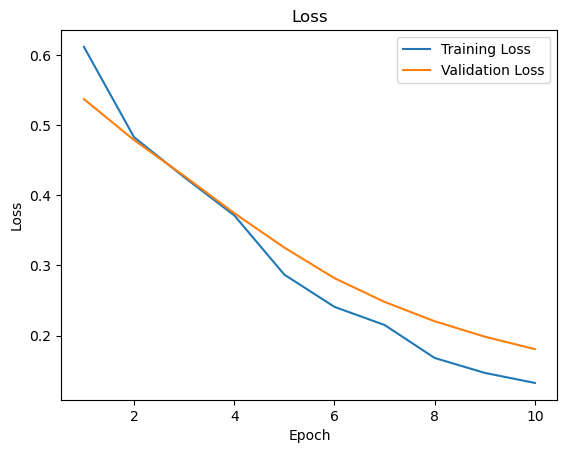

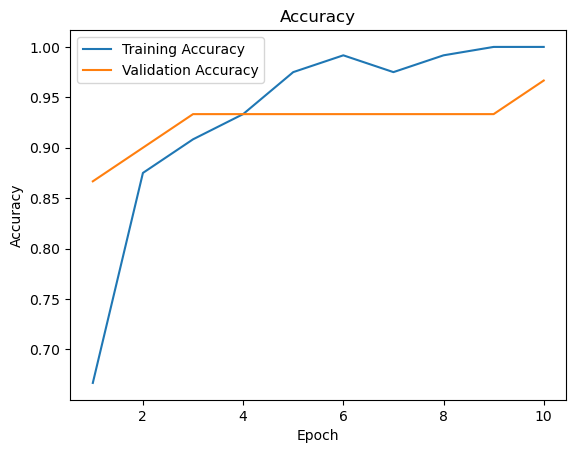

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

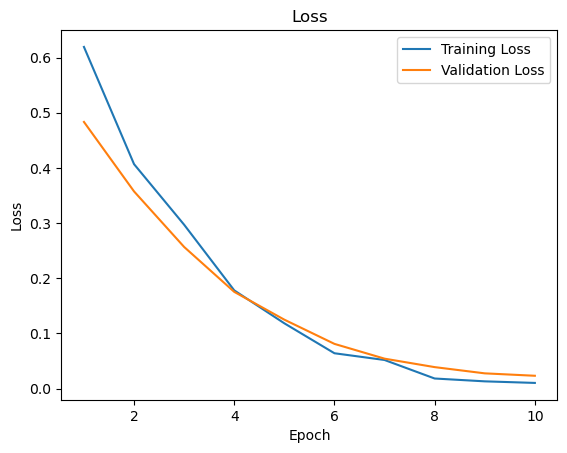

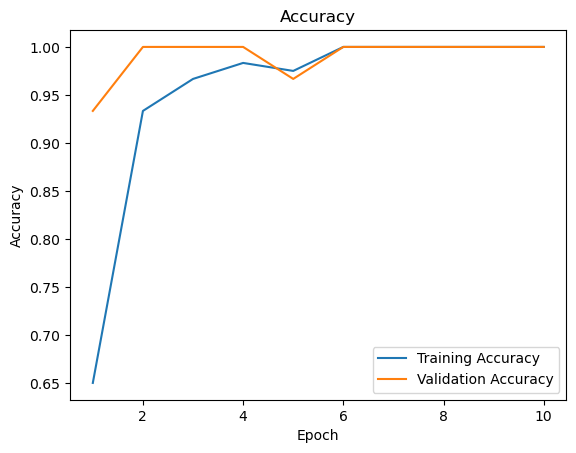

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000        30
   macro avg     1.0000    1.0000    1.0000        30
weighted avg     1.0000    1.0000    1.0000        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   3
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

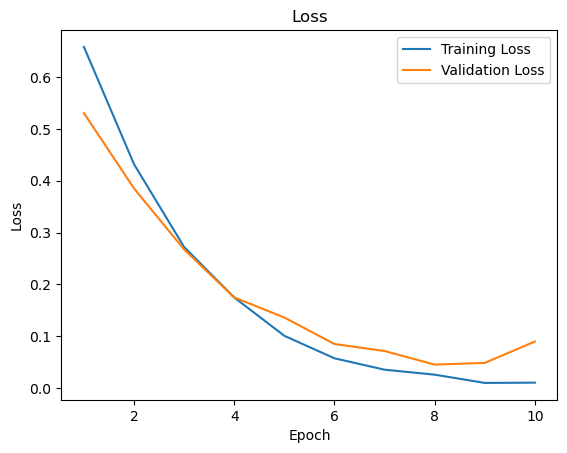

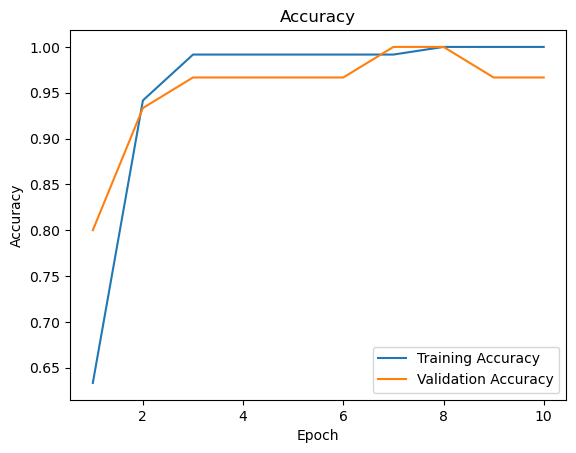

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   4
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

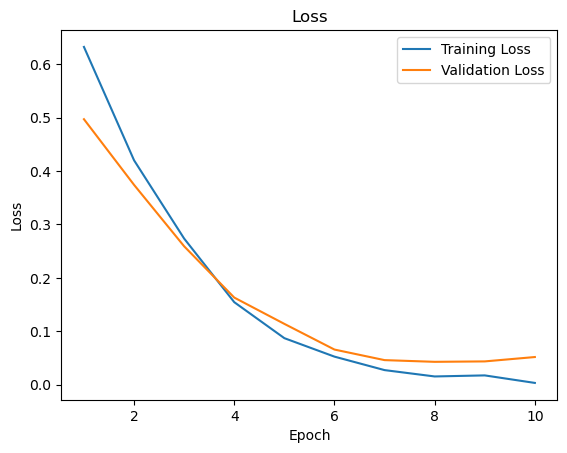

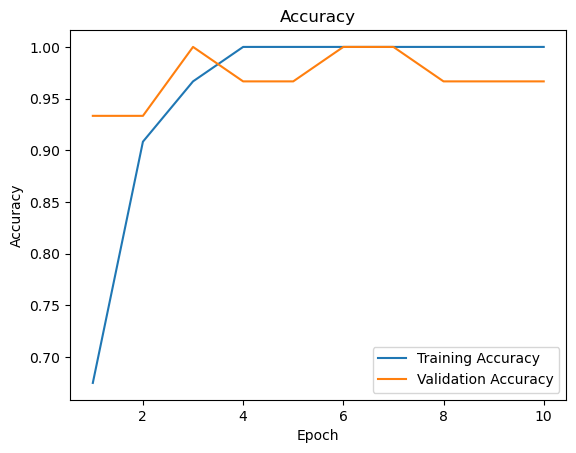

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   5
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

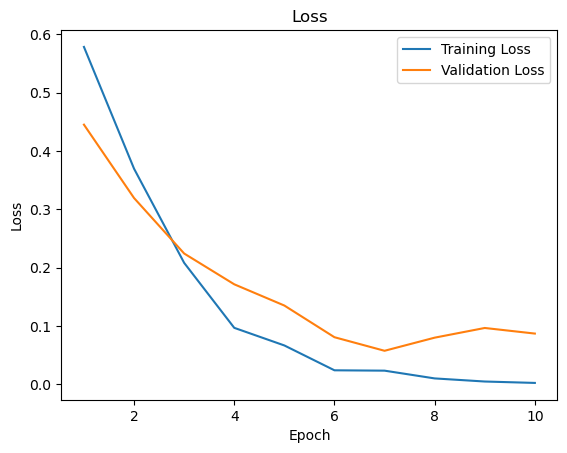

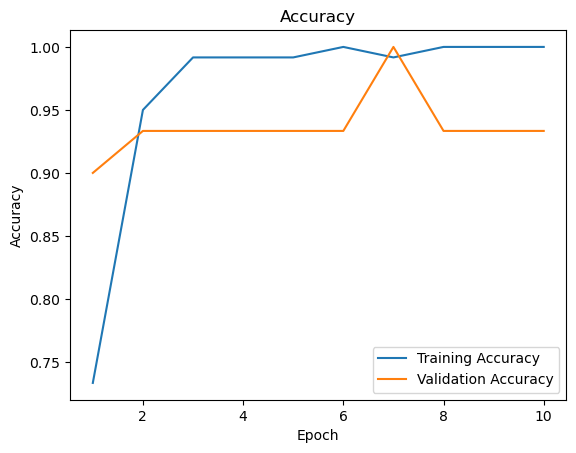

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        12
           1     0.9000    1.0000    0.9474        18

    accuracy                         0.9333        30
   macro avg     0.9500    0.9167    0.9282        30
weighted avg     0.9400    0.9333    0.9321        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   6
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

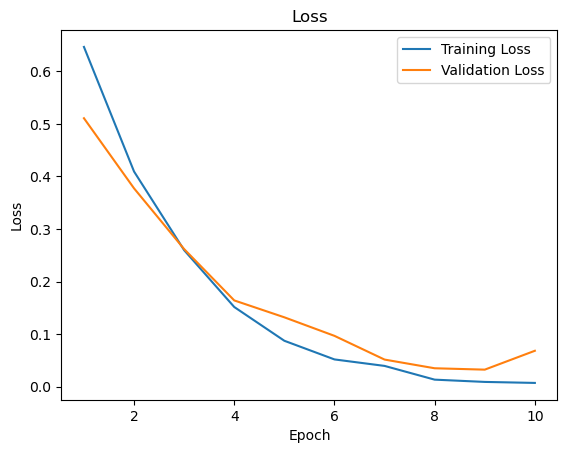

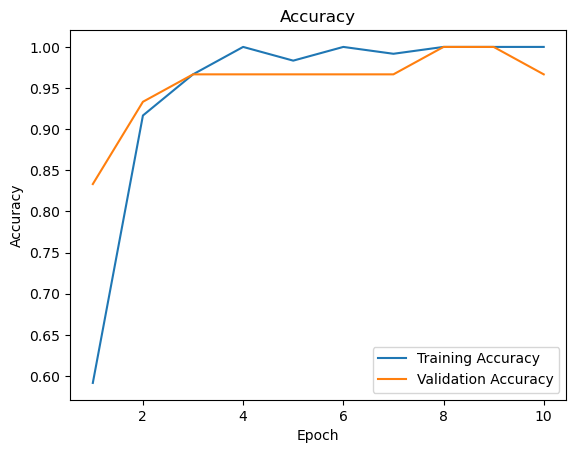

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30



In [3]:
for b in [1, 2, 3, 4, 5, 6]:
    exp[f'baseline_{b}'] = run_experiment(
        model={'unfreeze_blocks': b}
    )

## Learning Rates
Balance fast convergence against stability
- Too high a rate can skip over minima
- Too low may cause painfully slow training or getting stuck in poor local minima


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  10
training.learning_rate       :                0.00
training.optimizer           :                Adam
training.loss                : binary_crossentropy
training.metrics             :        ['accuracy']
callbacks.tensorboard_logdir :               logs/
callbacks.checkpoint_dir     :        checkpoints/

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150

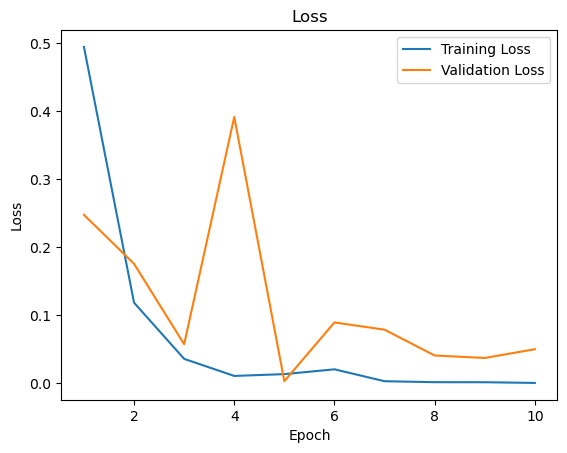

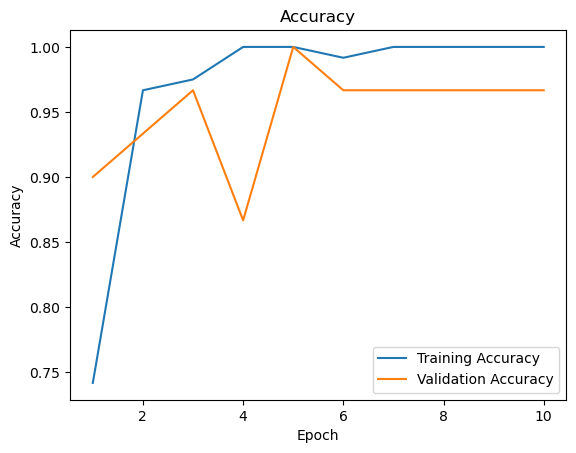

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

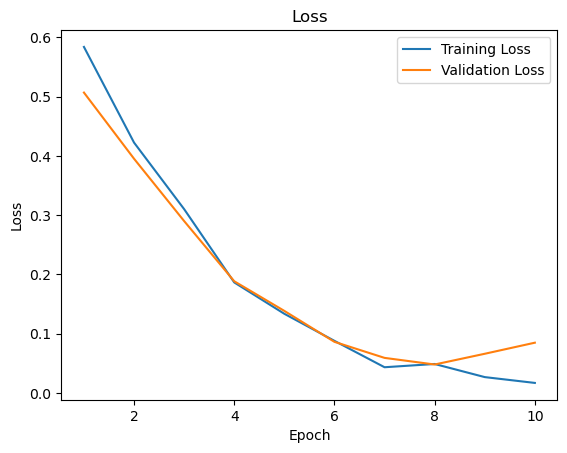

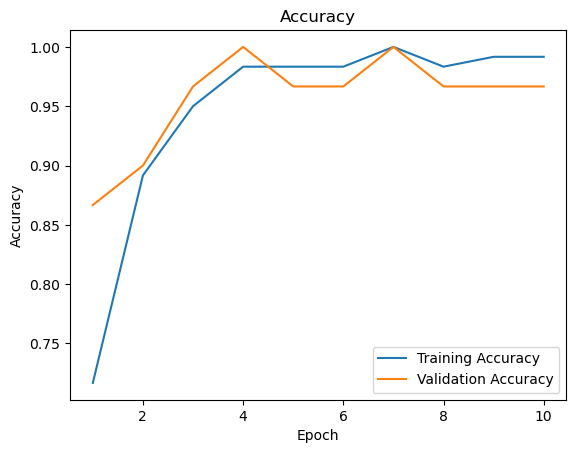

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

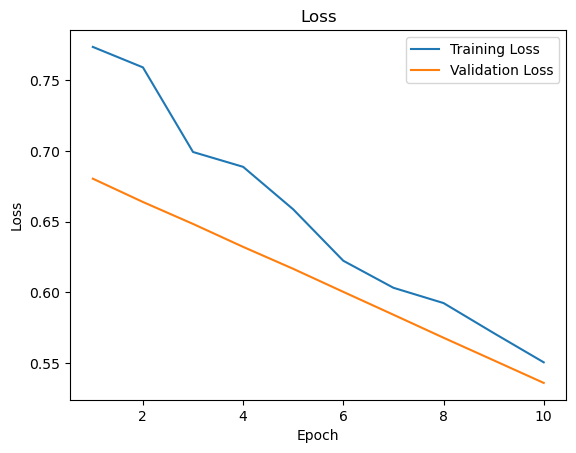

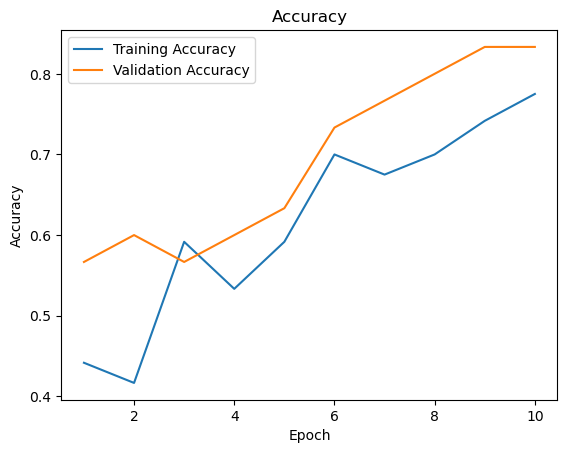

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8182    0.7500    0.7826        12
           1     0.8421    0.8889    0.8649        18

    accuracy                         0.8333        30
   macro avg     0.8301    0.8194    0.8237        30
weighted avg     0.8325    0.8333    0.8320        30



In [4]:
for lr in [1e-3, 1e-4, 1e-5]:
    exp[f'lr_{lr}'] = run_experiment(
        training={'learning_rate': lr}
    )

## Optimizer Variations
Different optimizers to assess optimization dynamics.


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  10
training.learning_rate       :                0.00
training.optimizer           :                 SGD
training.loss                : binary_crossentropy
training.metrics             :        ['accuracy']
callbacks.tensorboard_logdir :               logs/
callbacks.checkpoint_dir     :        checkpoints/

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150

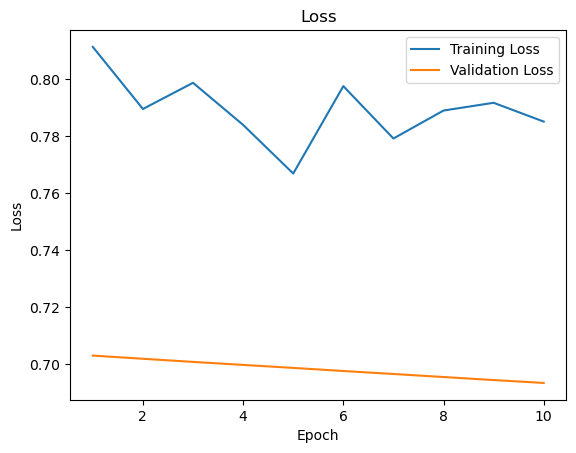

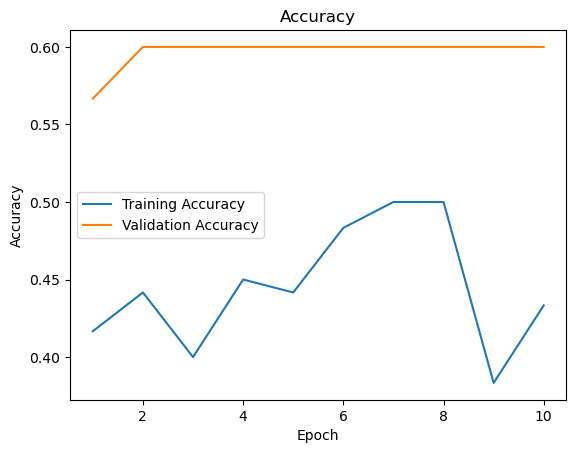

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     0.5000    0.1667    0.2500        12
           1     0.6154    0.8889    0.7273        18

    accuracy                         0.6000        30
   macro avg     0.5577    0.5278    0.4886        30
weighted avg     0.5692    0.6000    0.5364        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

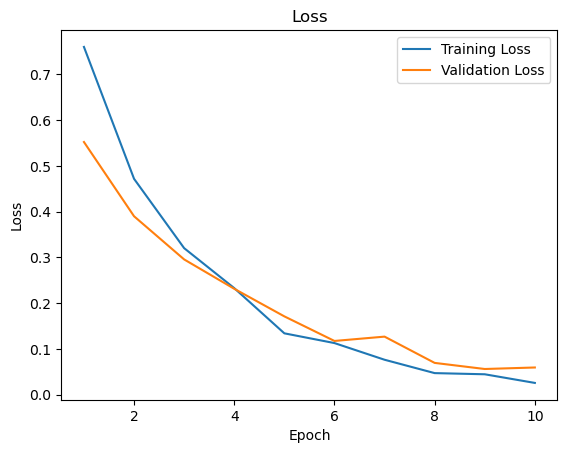

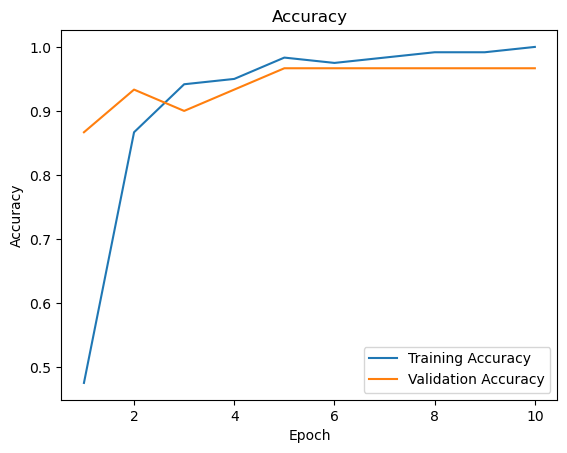

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

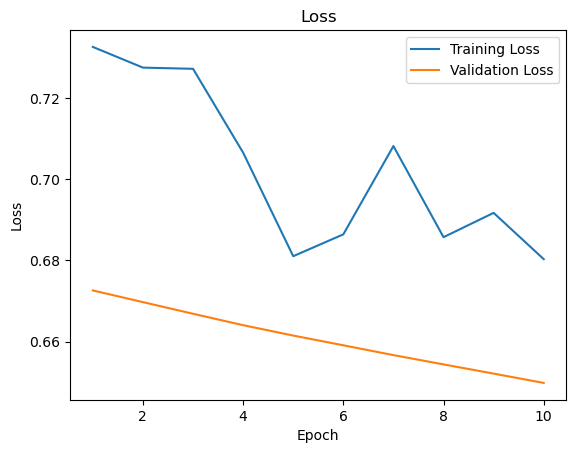

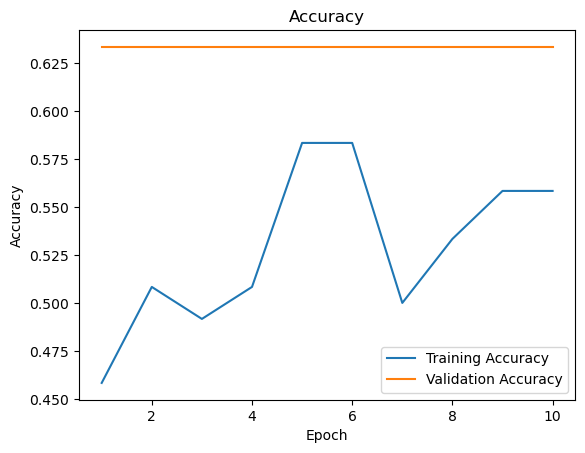

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     0.5294    0.7500    0.6207        12
           1     0.7692    0.5556    0.6452        18

    accuracy                         0.6333        30
   macro avg     0.6493    0.6528    0.6329        30
weighted avg     0.6733    0.6333    0.6354        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

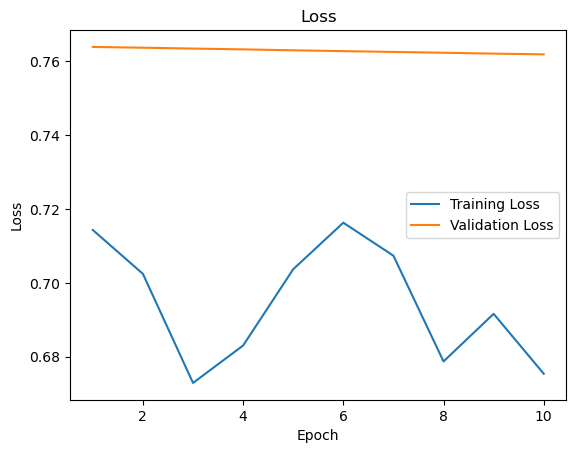

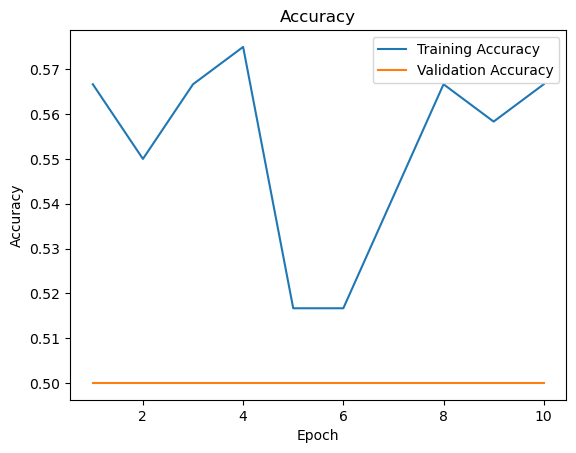

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     0.4400    0.9167    0.5946        12
           1     0.8000    0.2222    0.3478        18

    accuracy                         0.5000        30
   macro avg     0.6200    0.5694    0.4712        30
weighted avg     0.6560    0.5000    0.4465        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

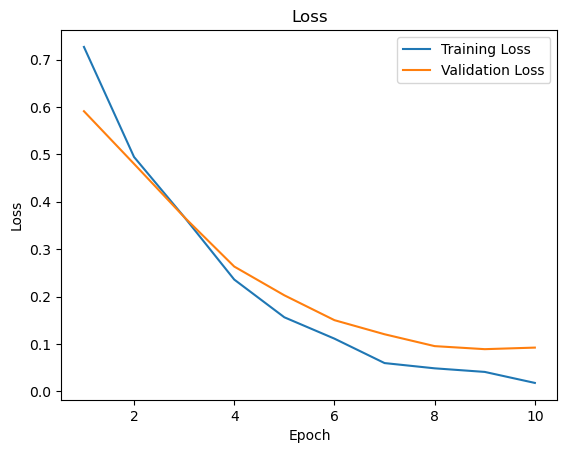

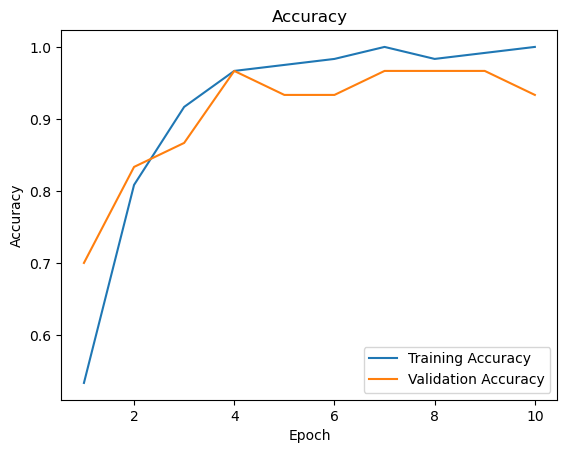

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        12
           1     0.9000    1.0000    0.9474        18

    accuracy                         0.9333        30
   macro avg     0.9500    0.9167    0.9282        30
weighted avg     0.9400    0.9333    0.9321        30



In [5]:
for opt in ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam']:
    exp[f'optimizer_{opt}'] = run_experiment(
        training={'optimizer': opt}
    )

## Dropouts
To find the balance between robustness and capacity
- Lower rates: make training more stable but might under-regularize
- higher rates: inject more noise to prevent co-adaptation of filters and combat overfitting


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  10
training.learning_rate       :                0.00
training.optimizer           :                Adam
training.loss                : binary_crossentropy
training.metrics             :        ['accuracy']
callbacks.tensorboard_logdir :               logs/
callbacks.checkpoint_dir     :        checkpoints/

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150

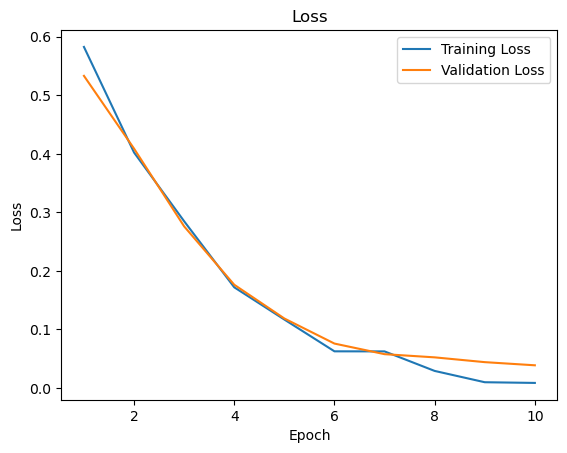

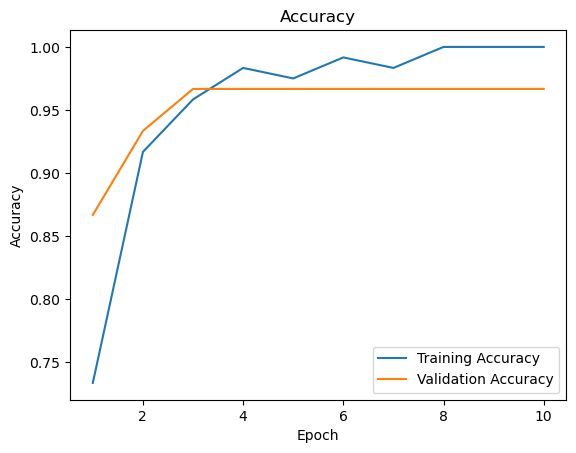

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.30
training.epochs              :                  1

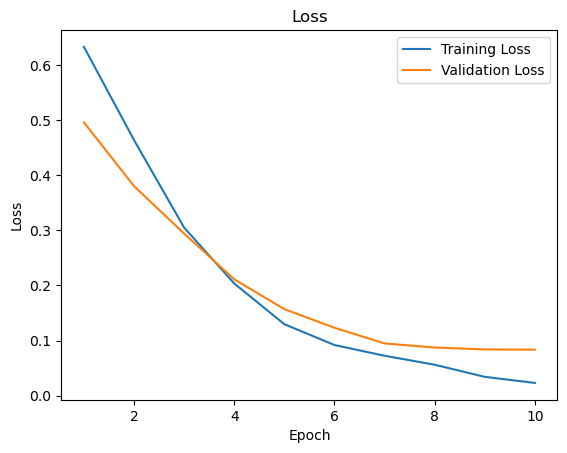

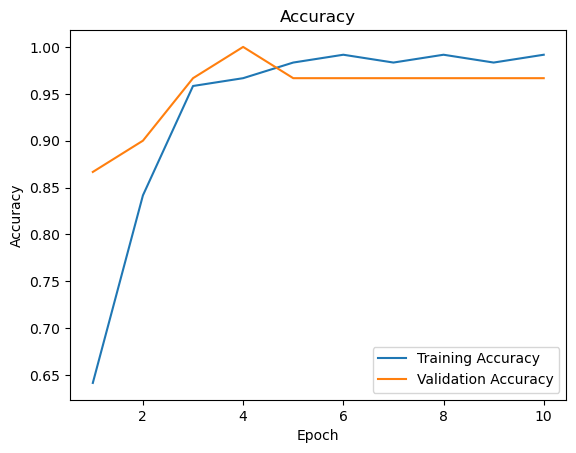

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.40
training.epochs              :                  1

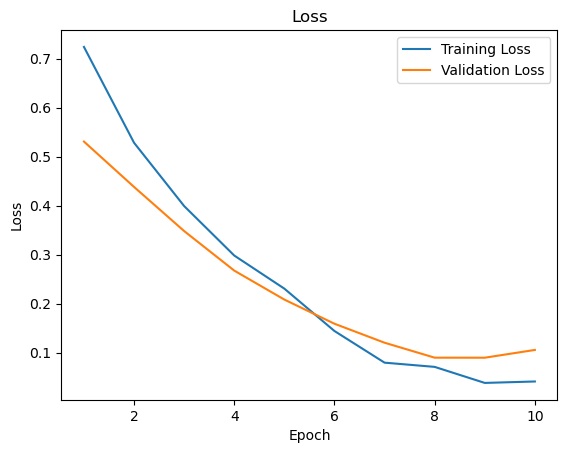

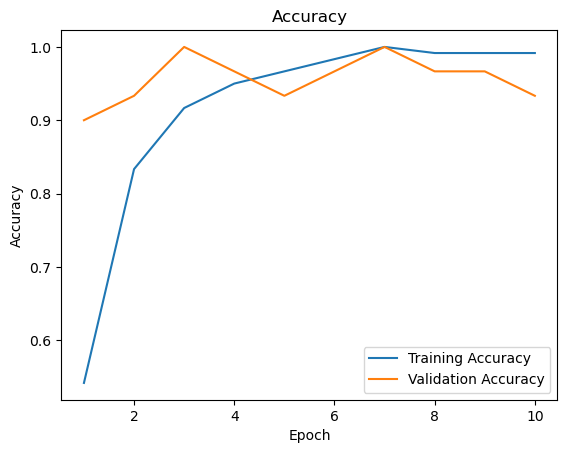

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        12
           1     0.9000    1.0000    0.9474        18

    accuracy                         0.9333        30
   macro avg     0.9500    0.9167    0.9282        30
weighted avg     0.9400    0.9333    0.9321        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.50
training.epochs              :                  1

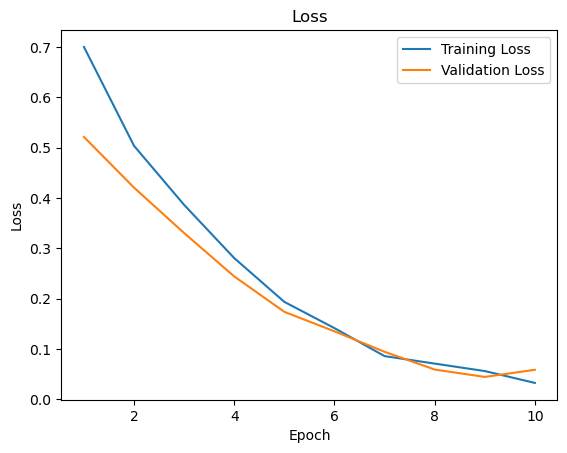

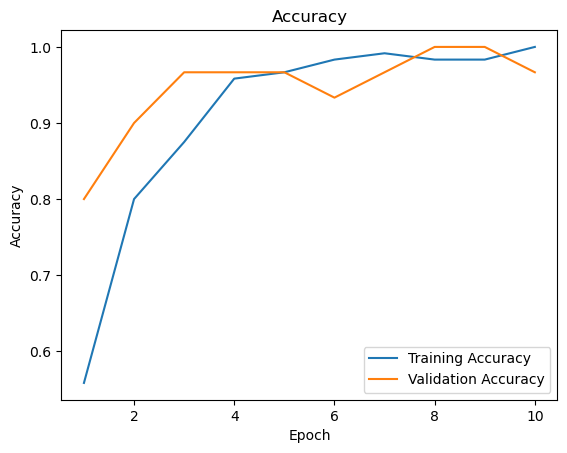

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.60
training.epochs              :                  1

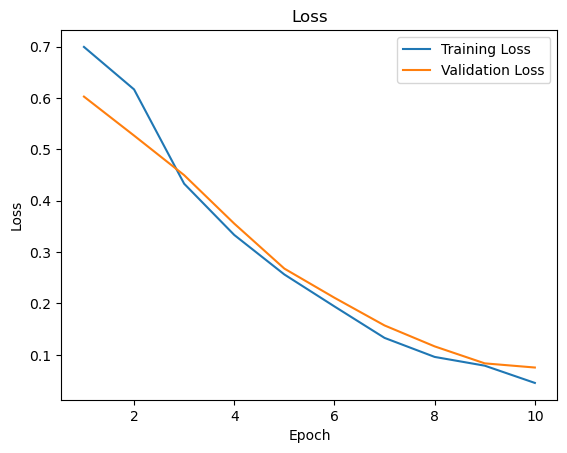

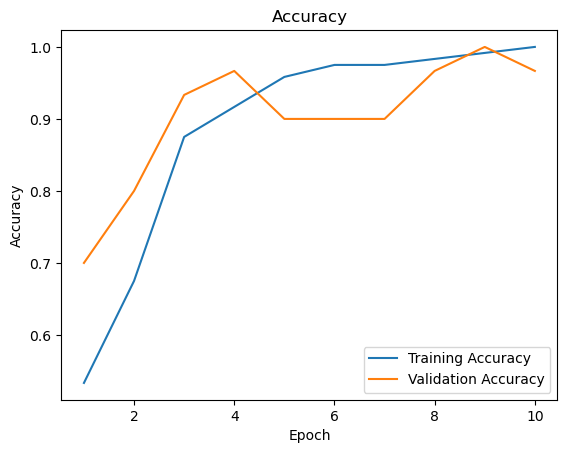

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.70
training.epochs              :                  1

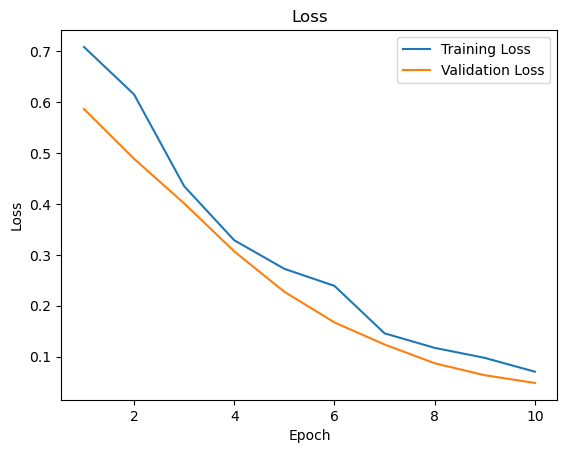

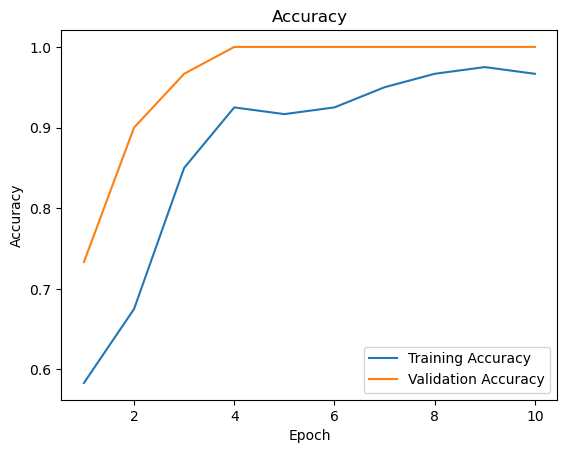

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000        30
   macro avg     1.0000    1.0000    1.0000        30
weighted avg     1.0000    1.0000    1.0000        30



In [6]:
for dr in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    exp[f'dropout_{dr}'] = run_experiment(
        model={'dropout_rate': dr}
    )

## Batch Size
Trade-off between gradient‐estimate noise and computational efficiency


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  32
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  10
training.learning_rate       :                0.00
training.optimizer           :                Adam
training.loss                : binary_crossentropy
training.metrics             :        ['accuracy']
callbacks.tensorboard_logdir :               logs/
callbacks.checkpoint_dir     :        checkpoints/

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150

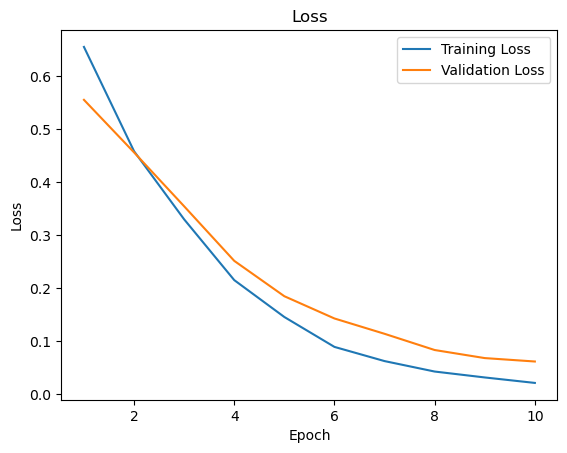

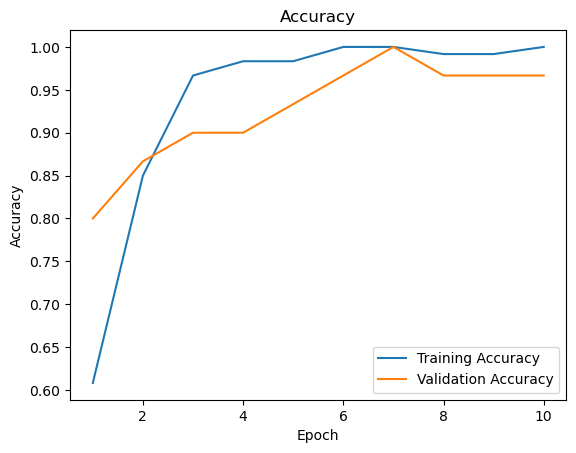

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  16
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

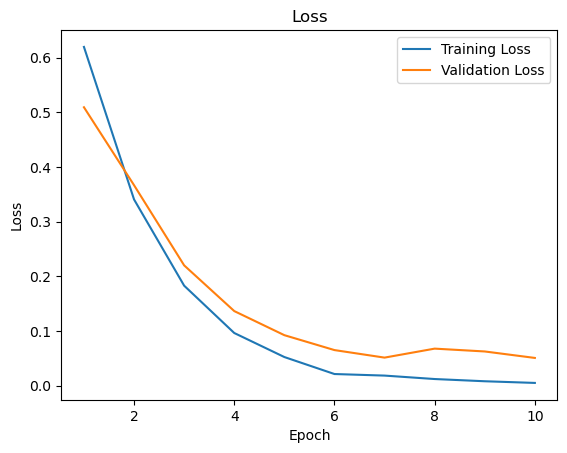

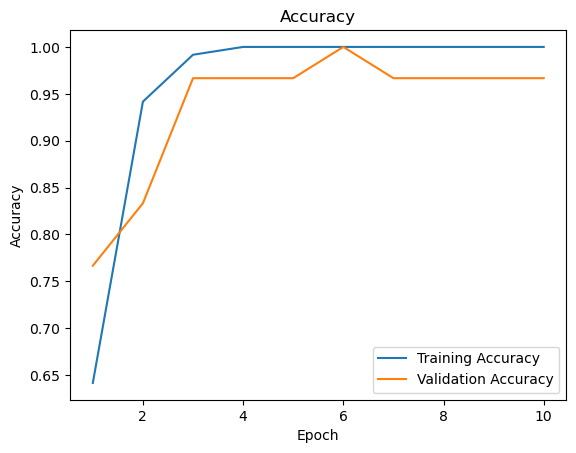

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                   8
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

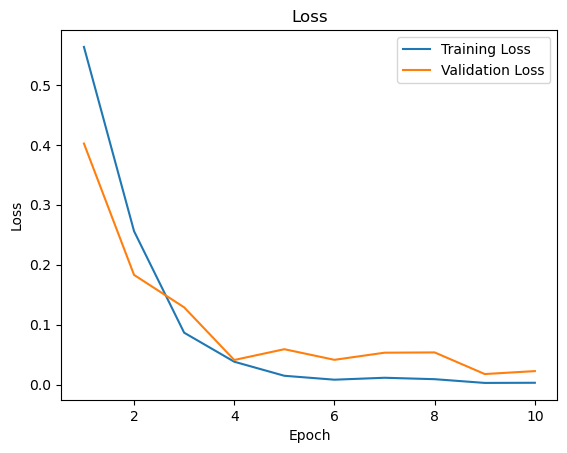

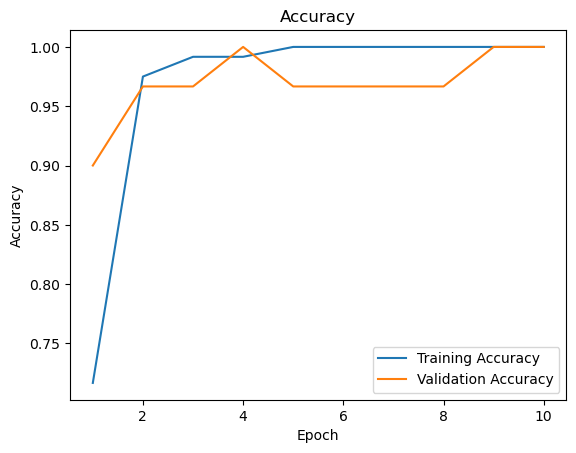

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000        30
   macro avg     1.0000    1.0000    1.0000        30
weighted avg     1.0000    1.0000    1.0000        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                   4
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

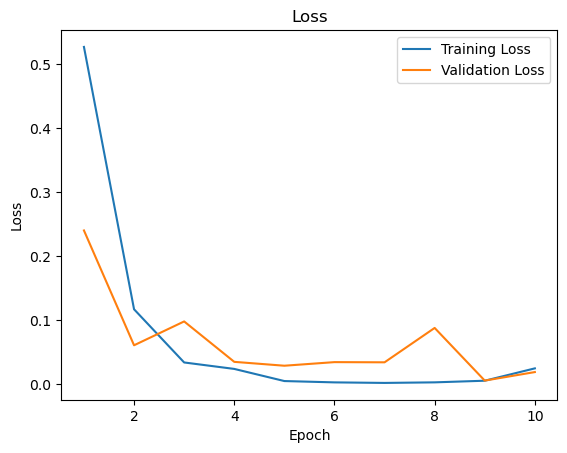

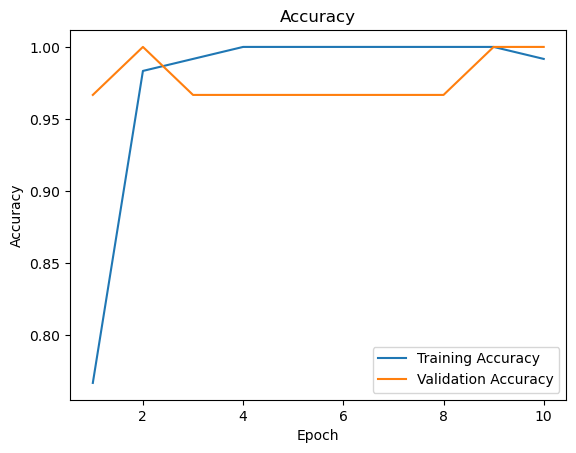

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000        30
   macro avg     1.0000    1.0000    1.0000        30
weighted avg     1.0000    1.0000    1.0000        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                   2
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

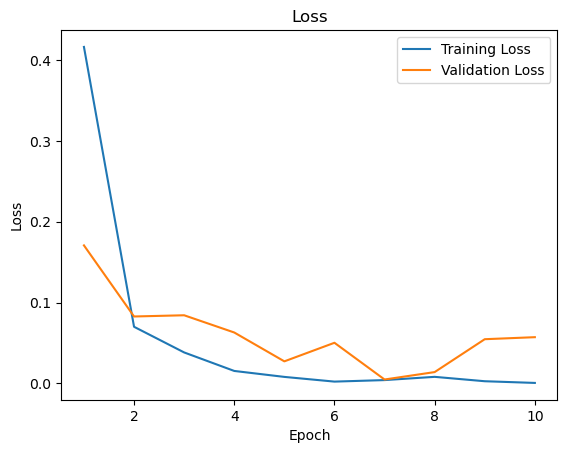

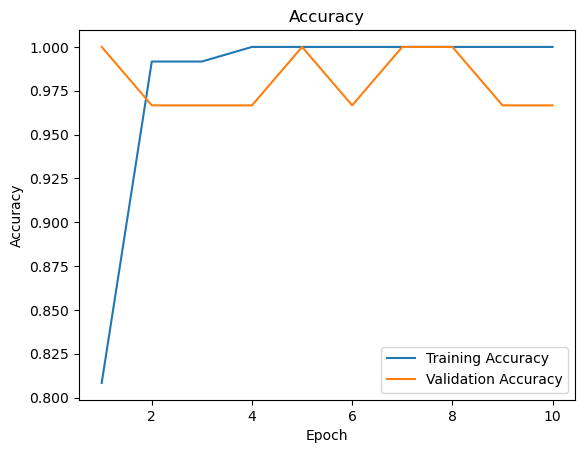

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                   1
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   2
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.20
training.epochs              :                  1

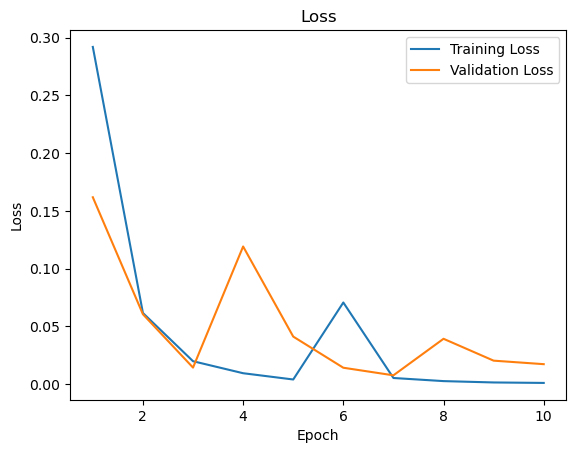

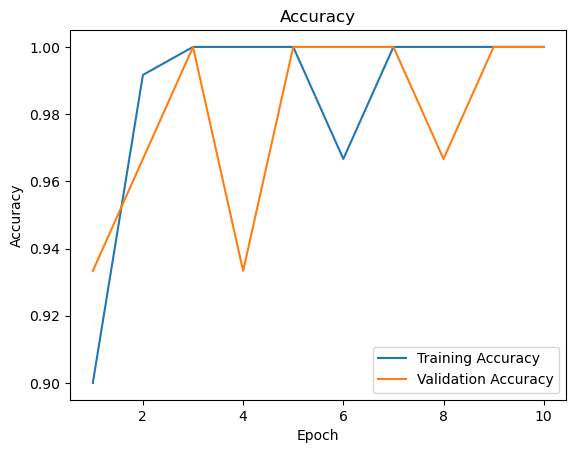

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000        18

    accuracy                         1.0000        30
   macro avg     1.0000    1.0000    1.0000        30
weighted avg     1.0000    1.0000    1.0000        30



In [7]:
for bs in [32, 16, 8, 4, 2, 1]:
    exp[f'batchsize_{bs}'] = run_experiment(
        data={'batch_size': bs}
    )

In [9]:
report_experiments(exp)

,Experiment,Category,Validation Accuracy,Validation Loss,Overfit Gap,Normalized Accuracy,Normalized Gap,Score
0,baseline_1,Blocks,0.9667,0.1806,0.0333,0.0000,0.5000,0.3750
1,baseline_2,Blocks,1.0000,0.3573,-0.0667,1.0000,1.0000,0.2500
2,baseline_3,Blocks,1.0000,0.0718,-0.0083,1.0000,0.1250,0.9063
3,baseline_4,Blocks,1.0000,0.2592,-0.0333,1.0000,0.5000,0.6250
4,baseline_5,Blocks,1.0000,0.0576,-0.0083,1.0000,0.1250,0.9063
5,baseline_6,Blocks,1.0000,0.0351,0.0000,1.0000,0.0000,1.0000
6,lr_0.001,Learning Rate,1.0000,0.0026,0.0000,1.0000,0.0000,1.0000
7,lr_0.0001,Learning Rate,1.0000,0.1886,-0.0167,1.0000,0.1818,0.8636
8,lr_1e-05,Learning Rate,0.8333,0.5520,-0.0917,0.0000,1.0000,0.0000
9,optimizer_SGD,Optimizers,0.6000,0.7020,-0.1583,0.2143,0.9048,0.1250


,Category,Experiment,Validation Accuracy,Validation Loss,Overfit Gap
0,Batch Sizes,batchsize_16,1.0000,0.0652,0.0000
1,Blocks,baseline_6,1.0000,0.0351,0.0000
2,Dropouts,dropout_0.6,1.0000,0.0833,-0.0083
3,Learning Rate,lr_0.001,1.0000,0.0026,0.0000
4,Optimizers,optimizer_Adam,0.9667,0.2632,0.0000


## Best Model
Test to see if the best in each set of experiments will produce a better performance


                 Experiment Config                 
data.data_dir                :                data
data.img_size                :                 224
data.batch_size              :                  16
data.validation_split        :                0.20
data.seed                    :                 123
model.backbone               :      EfficientNetB0
model.pretrained             :                True
model.unfreeze_blocks        :                   6
model.blocks_to_unfreeze     :                None
model.dropout_rate           :                0.60
training.epochs              :                  10
training.learning_rate       :                0.00
training.optimizer           :                Adam
training.loss                : binary_crossentropy
training.metrics             :        ['accuracy']
callbacks.tensorboard_logdir :               logs/
callbacks.checkpoint_dir     :        checkpoints/

Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150

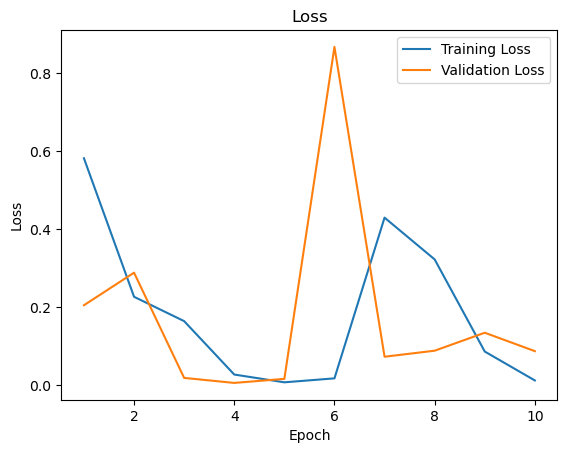

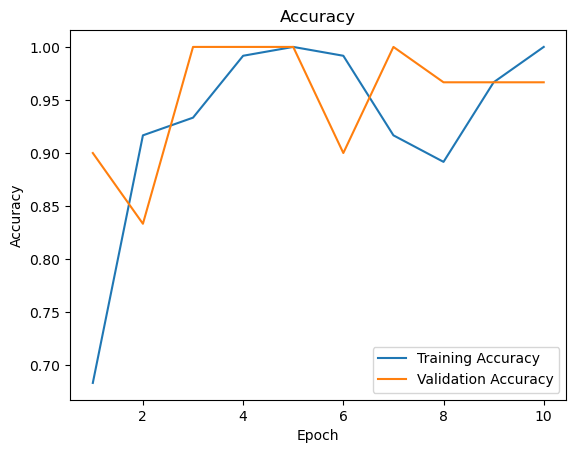

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9167    0.9565        12
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9667        30
   macro avg     0.9737    0.9583    0.9647        30
weighted avg     0.9684    0.9667    0.9664        30



In [10]:
exp['best'] = run_experiment(
    data={
        'batch_size': 16
    },
    model={
        'unfreeze_blocks': 6,
        'dropout_rate': 0.6
    },
    training={
        'epochs': 30,
        'learning_rate': 1e-3,
        'optimizer': 'Adam'
    }
)